In [1]:

import os
import shutil
import re
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')


load_dotenv()

True

In [2]:
def savefigtight(figname):
  if not os.path.exists("images"):
    os.makedirs("images")
  plt.savefig(os.path.join("images", figname))

carr=[]

cmap_tab = lambda position : mpl.colormaps['tab20c'](position)
cmap_tab2 = lambda position : mpl.colormaps['tab10'](position)
cmap_tvt = lambda split: mpl.colormaps['tab20c'](0.2 if split=="tr" else 0.35 if split=="te" else 0.25)
cmap_sex = lambda sex_f: mpl.colormaps['tab20'](0.0 if sex_f==1 else 0.05)


In [3]:
abbr = {"EOD": "Equal odds difference (EOD)", "AOD": "Average odds difference (AOD)", "DI": "Disparate impact (DI)", "SPD": "Statistical parity index (SPD)", "ACC": "Accuracy (ACC)", "REC":"Recall (REC)", "MCC":"Matthews correlation coefficient (MCC)", "SPE":"Specificity (SPE)"}
abbr_n = {"EOD": "Equal odds\ndifference (EOD)", "AOD": "Average odds\ndifference (AOD)", "DI": "Disparate impact\n(DI)", "SPD": "Statistical parity\nindex (SPD)", "ACC": "Accuracy\n(ACC)", "REC":"Recall (REC)", "MCC":"Matthews correlation\ncoefficient (MCC)", "SPE":"Specificity\n(SPE)"}

In [4]:

def addTFNP(df):
  tpfn = []
  tpfn_full = []
  for index, row in df.iterrows():
      cm_val = ""
      cm_long = ""
      if row["TF"] ==1:
         cm_val = "T"
         cm_long = "true "
      else:
        cm_val = "F"
        cm_long = "false "

      cm_val +=  "P" if row["Prediction"] == 1 else "N"
      cm_long +=  "positive" if row["Prediction"] == 1 else "negative"
      tpfn+=[cm_val]
      tpfn_full+=[cm_long]
  df_n = df.copy(deep=True)
  df_n["CM"] = tpfn
  df_n["CM_full"] = tpfn_full
  return df_n


def getAnalysisDF():
  df_raw = pd.read_excel(os.getenv("RAWTAB"))
  df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTTAB"))["MRI ID"].unique())]

  df_norm= pd.read_excel(os.getenv("NORMTAB"))
  df_norm= df_norm[df_norm["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTTAB"))["MRI ID"].unique())]

  df_combo = pd.merge(left=df_raw, right=df_norm, on="MRI ID", suffixes=["_raw", "_norm"], how="outer")
  df_pred = pd.merge(df_combo, pd.read_excel(os.getenv("PREDICTTAB")).drop(columns=["Group"]), how="outer")
  return addTFNP(df_pred)

def getSplitDF():
    df_split = pd.read_excel(os.getenv("SPLITTAB"))
    df_raw = pd.read_excel(os.getenv("RAWTAB"))
    df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel(os.getenv("SPLITTAB"))["MRI ID"].unique())]

    df_split = pd.merge(left=df_split, right=df_raw, on="MRI ID", suffixes=["_norm", "_raw"], how="outer")
    return df_split


df_pred = getAnalysisDF()
df_split = getSplitDF()


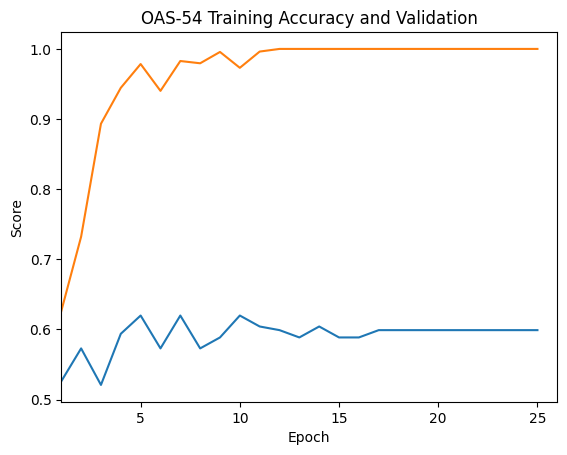

In [5]:
df_h = pd.read_excel(os.getenv("TRAININGTAB"))

plt.plot(df_h["Epoch"],df_h["Validation_accuracy"], label="Validation Accuracy")
plt.plot(df_h["Epoch"],df_h["Training_accuracy"], label="Training Accuracy")

plt.title("OAS-54 Training Accuracy and Validation")
plt.xlim(1,26)

plt.xlabel("Epoch")
plt.ylabel("Score")

savefigtight("training-validation.png")
plt.show()

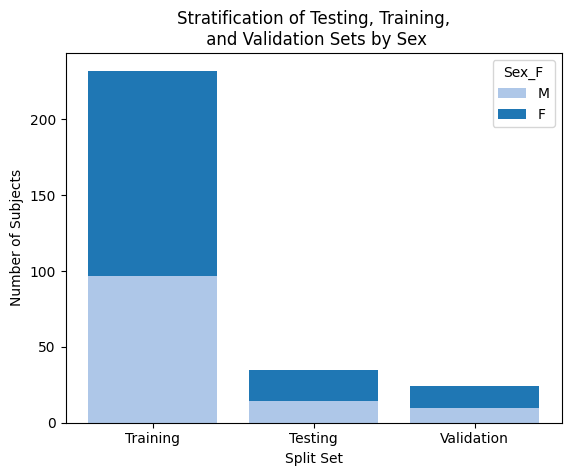

In [6]:
x = np.arange(len(df_split["Split"].unique()))
# print(df_split["Split"].unique())
wid = 0.3
m = 0


plt.bar(x+wid, df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="M", color=cmap_sex(0))
plt.bar(x+wid, df_split[df_split["Sex_F"]==1]["Split"].value_counts(), bottom=df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="F", color=cmap_sex(1))

plt.xticks(x+wid, ["Training", "Testing", "Validation"])

plt.legend(title="Sex_F")
plt.title("Stratification of Testing, Training,\n and Validation Sets by Sex")
plt.xlabel("Split Set")
plt.ylabel("Number of Subjects")
savefigtight("sex-strat.png")

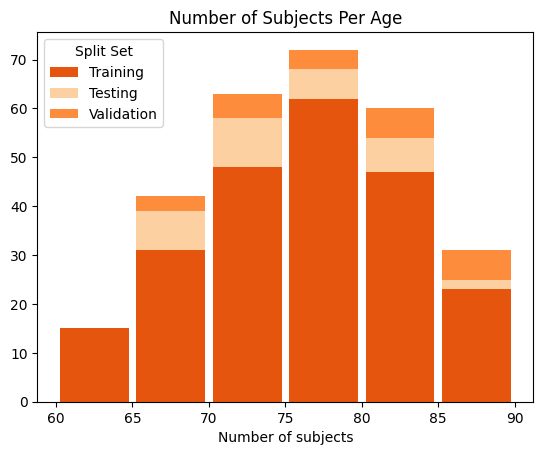

In [7]:
bins =  np.arange(60,95,5)
hist_tr = np.histogram(df_split[df_split["Split"]=="train"]["Age_raw"], bins)
hist_te = np.histogram(df_split[df_split["Split"]=="test"]["Age_raw"],     bins)
hist_va = np.histogram(df_split[df_split["Split"]=="validate"]["Age_raw"], bins)
wid = 0.9


plt.bar(np.arange(0,len(hist_tr[0]), 1), hist_tr[0], label="Training",width=wid, color=cmap_tvt("tr"))
plt.bar(np.arange(0,len(hist_te[0]), 1), hist_te[0], bottom=hist_tr[0], label="Testing", width=wid, color=cmap_tvt("te"))
plt.bar(np.arange(0,len(hist_va[0]), 1), hist_va[0], bottom=hist_tr[0] + hist_te[0], label="Validation", width=wid, color=cmap_tvt("va"))
plt.xticks(np.arange(0,len(hist_tr[0])+1, 1)-0.5, labels=bins)
plt.legend(title="Split Set")
plt.title("Number of Subjects Per Age")
plt.xlabel("Age (years)")
plt.xlabel("Number of subjects")
savefigtight("age-strat.png")
plt.show()


In [8]:



recall = lambda df : float(len(df.query('CM == "TP"')))/(float(len(df.query('CM == "TP"'))+len(df.query('CM == "FN"'))) if float(len(df.query('CM == "TP"'))+len(df.query('CM == "FN"')))!=0 else 1.)
specificity = lambda df : float(len(df.query('TF == 1 & Prediction == 0')))/(float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) if float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) != 0 else 1.)
accuracy = lambda df : float(len(df.query('TF == 1')))/len(df)

tpr = lambda df: recall(df)

fpr = lambda df : float(len(df.query('TF == 0 & Prediction == 1')))/(float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) if float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1')))!=0 else 1.)

In [9]:
import math

def getRec(df):
  tp = float(len(df.query('TF == 1 & Prediction == 1')))
  fn = float(len(df.query('TF == 0 & Prediction == 0')))
  if tp+fn == 0:
    return 1
  else:
    return tp/(fn+tp)

def getTPR(df):
  tp = float(len(df.query('TF == 1 & Prediction == 1')))
  fn = float(len(df.query('TF == 1 & Prediction == 0')))
  if tp+fn == 0:
    return 1
  else:
    return tp/(tp+fn)

getTPR(df_pred)

def getFPR(df):
  tn = float(len(df.query('TF == 1 & Prediction == 0')))
  fp = float(len(df.query('TF == 0 & Prediction == 1')))
  if fp+tn == 0:
    return 1
  else:
    return fp/(tn+fp)

def getSpec(df):
  tn = len(df.query('TF == 1 & Prediction == 0'))
  fp = len(df.query('TF == 0 & Prediction == 1'))
  if (fp+tn) == 0:
    return 1
  else:
    return float(tn)/(fp+tn)

def getAcc(df):
  return float(len(df[df["TF"]==1]))/len(df)

def getMCC(df):
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  tn = float(len(df.query('TF == 1 and Prediction == 0')))
  fp = float(len(df.query('TF == 0 and Prediction == 1')))
  fn = float(len(df.query('TF == 0 and Prediction == 0')))

  numer = (tp*tn)-(fp*fn)
  denom = math.sqrt((tp + fp)*(tp + fn)*(tn+fp)*(tn+fn))
  if denom ==0:
    return 1
  else:
    return (numer)/(denom)


def getEOD(df_priv, df_npriv):
  rec_a = recall(df_priv)
  rec_b = recall(df_npriv)
  return rec_b-rec_a

def getAOD(df_priv, df_npriv):

  tpr_a = tpr(df_priv)
  tpr_b = tpr(df_npriv)


  fpr_a = fpr(df_priv)
  fpr_b = fpr(df_npriv)


  return ((fpr_b-fpr_a)+(tpr_b-tpr_a))/2.

def getDI(df_priv, df_npriv):

  a = float(len(df_npriv.query("Prediction==1")))/(1. if len(df_npriv)==0 else len(df_npriv))
  b = float(len(df_priv.query("Prediction==1")))/(1. if len(df_priv)==0 else len(df_priv))

  return a/(1. if b==0 else b)

def getSPD(df_priv, df_npriv):
  a = float(len(df_npriv.query("Prediction==1")))/(1. if len(df_npriv)==0 else len(df_npriv))
  b = float(len(df_priv.query("Prediction==1")))/(1. if len(df_priv)==0 else len(df_priv))
  return a-b

def getAccDiff(df_priv, df_npriv, asPercent=False):
  a = accuracy(df_npriv)
  b = accuracy(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getRecDiff(df_priv, df_npriv, asPercent=False):
  a = recall(df_npriv)
  b = recall(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getSpecDiff(df_priv, df_npriv, asPercent=False):
  a = specificity(df_npriv)
  b = specificity(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getMCCDiff(df_priv, df_npriv, asPercent=False):
  a=getMCC(df_npriv)
  b=getMCC(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b


def getFairness(df_priv, df_npriv):
  return pd.DataFrame({"DI": [getDI(df_priv, df_npriv)], "EOD":[getEOD(df_priv, df_npriv)], "AOD":[getAOD(df_priv, df_npriv)], "SPD":[getSPD(df_priv, df_npriv)]})


def printComparison(df_a, df_b, title_a="A", title_b="B"):
  print("-"*80)
  print(f"COMPARISON {title_a} vs. {title_b}")
  print("·"*40)
  print(f'Accuracy difference ({title_a} vs. {title_b}):   \t{getAccDiff(df_a, df_b , asPercent=True):+.2f}%')
  print(f'Recall difference ({title_a} vs. {title_b}):     \t{getRecDiff (df_a, df_b, asPercent=True):+.2f}%')
  print(f'Specificity difference ({title_a} vs. {title_b}):\t{getSpecDiff(df_a, df_b, asPercent=True):+.2f}%')
  print(f'MCC difference ({title_a} vs. {title_b}):        \t{getMCCDiff(df_a, df_b , asPercent=True):+.2f}%')
  print()
  print(f'Equal opportunity difference (EOD):\t{getEOD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getEOD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Average odds difference (AOD):     \t{getAOD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getAOD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Disparate impact (DI):             \t{getDI(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getDI(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Statistical parity index (SPD):    \t{getSPD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getSPD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print("-"*80)


In [10]:
print(f'Accuracy:       {accuracy(df_pred):5.3f}')
print(f'Recall:         {recall(df_pred):5.3f}')
print(f'Specificity:    {specificity(df_pred):5.3f}')
print(f'MCC:            {getMCC(df_pred):+5.3f}')


Accuracy:       0.839
Recall:         0.808
Specificity:    0.863
MCC:            +0.672


In [11]:
def getMetrics(df, title=""):
  if len(df) < 1:
    return pd.DataFrame({"ACC":[0.], "SPE":[0.], "REC":[0.], "MCC":[0.0]})
  acc =  [getAcc(df)]
  spec = [getSpec(df)]
  rec = [getRec(df)]
  mcc = [getMCC(df)]
  return pd.DataFrame({"ACC":acc, "SPE":spec, "REC":rec, "MCC":mcc})

def getSexMetrics(df):
  df_f = getMetrics(df[df["Sex_F"]==1])
  df_m = getMetrics(df[df["Sex_F"]==0])
  df_f["Sex_F"] = [1]
  df_m["Sex_F"] = [0]
  return pd.merge(df_f, df_m, how="outer")

def getAgeRange(df, min, max):
  df_t = df[df["Age_raw"]>=min]
  df_t = df_t[df_t["Age_raw"]<max]
  df_t["Age_range"] = f'{min:d} to {max-1:d}'
  return df_t, f'{min:d} to {max-1:d}'

def getAgeMetrics(df):

  df_age = pd.DataFrame(columns=["Age","ACC","SPE","REC","MCC"])

  bins = np.arange(65, 100, 5)


  for i in bins[:-1]:
    df_t, age_range = getAgeRange(df, i, i+5)
    df_m = getMetrics(df_t)
    df_m["Age"] = age_range
    df_age = pd.merge(df_age, df_m, how="outer")

  return df_age

def getAgeSexMetrics(df):
  df_age = pd.DataFrame(columns=["Age_range","M/F","ACC","SPE","REC","MCC"])

  bins = np.arange(65, 100, 5)

  df_f = df[df["M/F"]=="F"]
  df_m = df[df["M/F"]=="M"]


  for i in bins[:-1]:
    df_tf, age_range = getAgeRange(df_f, i, i+5)
    df_tm, age_range = getAgeRange(df_m, i, i+5)

    df_metf = getMetrics(df_tf)
    df_metm = getMetrics(df_tm)

    df_metm["M/F"] = ["M"]
    df_metf["M/F"] = ["F"]
    df_metm["Age_range"] = age_range
    df_metf["Age_range"] = age_range
    df_met = pd.merge(df_metf, df_metm, how="outer")


    df_age = pd.merge(df_age, df_met, how="outer")
  return df_age


In [12]:
df_sex = getSexMetrics(df_pred)
df_age = getAgeMetrics(df_pred)
df_age_sex = getAgeSexMetrics(df_pred)


        ACC     SPE       REC       MCC
0  0.839286  0.8625  0.808333  0.671551


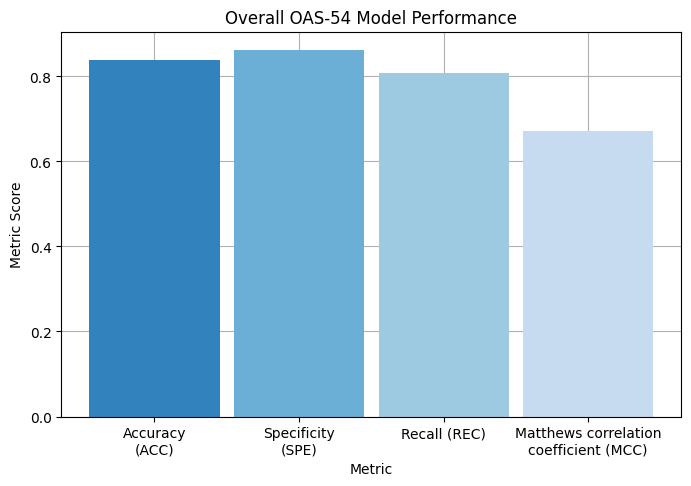

In [13]:
df_overall = getMetrics(df_pred)

width=0.2
i = 0
ticks = np.arange(0,len(df_overall.keys()), 1)
plt.figure(figsize=(8,5))
ax = plt.subplot()
ax.set_xlabel("Metric")
ax.set_ylabel("Metric Score")
ax.set_title("Overall OAS-54 Model Performance")

ax.bar(ticks, df_overall.iloc[0], width=0.9, color=[cmap_tab(i) for i in np.arange(0.0, 0.2, 0.05)])
ax.grid(visible=True)
ax.set_xticks(ticks, labels=[abbr_n[k] for k in  df_overall.keys()])
ax.set_axisbelow(True)

savefigtight("overall-performance.png")

print(df_overall)

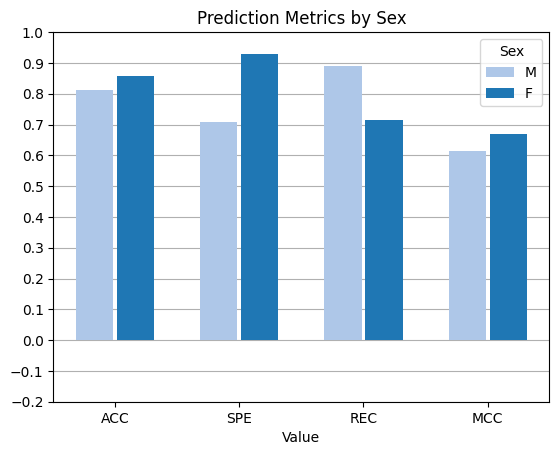

        ACC       SPE       REC       MCC  Sex_F
0  0.812500  0.708333  0.890625  0.615299      0
1  0.857143  0.928571  0.714286  0.670820      1


In [14]:

x_ticks = np.linspace(0,5,len(df_sex.keys())-1)
wid = 0.5
padding = 0.05
i = 0

fig, ax = plt.subplots()

for s in df_sex["Sex_F"].unique():
  row = df_sex[df_sex["Sex_F"]==s].values[0][:-1]
  oset = (wid+padding)*i
  ax.bar(x=x_ticks+oset, height=row, width=wid, label=("F" if s==1 else "M"), color=cmap_sex(s))
  i+=1
  ax.set_xticks(x_ticks+(wid+padding)/2, labels=df_sex[df_sex["Sex_F"]==s].keys()[:-1])
  ax.set_yticks(np.arange(-0.2,1.1,0.1))
ax.legend(title="Sex")
ax.set_xlabel("Metric")
ax.set_xlabel("Value")
ax.set_title("Prediction Metrics by Sex")
ax.grid(visible=True, axis='y',zorder=-1)
ax.set_axisbelow(True)
plt.savefig("sex-metrics.png", bbox_inches="tight")
plt.show()

print(df_sex)


        DI       EOD       AOD       SPD
0  2.21875  0.176339  0.198289  0.348214


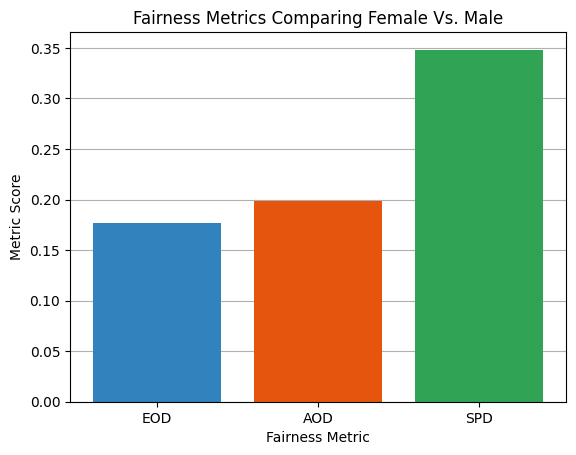

In [15]:
eq_sex = getFairness(df_pred[df_pred["Sex_F"]==1], df_pred[df_pred["Sex_F"]==0])
print(eq_sex)
fig, ax = plt.subplots()

ax.grid(visible=True, axis='y')
ax.bar(eq_sex.keys()[1:], eq_sex.iloc[0][1:], color=[cmap_tab(t) for t in np.arange(0, 1, 0.2)])
ax.set_title("Fairness Metrics Comparing Female Vs. Male")
ax.set_xlabel("Fairness Metric")
ax.set_ylabel("Metric Score")
ax.set_axisbelow(True)
savefigtight("fairness-sex.png")
plt.show()

In [16]:
def fairnessByAge(df):
  df_met = pd.DataFrame(columns=["Age_range", "Weight", "DI","EOD", "AOD", "SPD"])

  bins = np.arange(65, 100, 5)
  for i in bins[:-1]:
    df_age, age_range = getAgeRange(df, i, i+5)
    df_nAge = df.drop(df[df["MRI ID"].isin(df_age["MRI ID"])].index)
    weight = float(len(df_age))/len(df_nAge)
    df_a = getFairness(df_nAge, df_age)
    df_a["Weight"] = weight
    df_a["Age_range"] = age_range
    df_met =pd.merge(df_met, df_a, how='outer')

  return df_met

def fairnessByUnique(df, key):
  df_met = pd.DataFrame(columns=[key, "Weight", "DI","EOD", "AOD", "SPD"])
  for val in df[key].unique():
    df_in = df[df[key] == val]
    df_out = df[df[key]!=val]
    weight = float(len(df_in))/len(df_out)
    df_fair = getFairness(df_out, df_in)
    df_fair[key] = val
    df_fair["Weight"] = weight

    df_met =pd.merge(df_met, df_fair, how='outer')
  return df_met.sort_values(by=key)

def fairnessByRange(df, key, numBins):

  df_met = pd.DataFrame(columns=[key, "Weight", "DI","EOD", "AOD", "SPD"])
  bins = np.linspace(df[key].min(), df[key].max(), numBins)
  for i in range(len(bins)-1):
    low = bins[i]
    high = bins[i+1]

    df_in = df.query(key + " <= @high & " + key + " > @low")
    df_out = df.drop(df[df[key].isin(df_in[key])].index)

    weight = float(len(df_in))/len(df_out)
    df_fair = getFairness(df_out, df_in)
    df_fair[key] = (low+high)/2.
    df_fair["Weight"] = weight

    df_met =pd.merge(df_met, df_fair, how='outer')
  return df_met.sort_values(by=key)


df_age_fairness = fairnessByAge(df_pred)


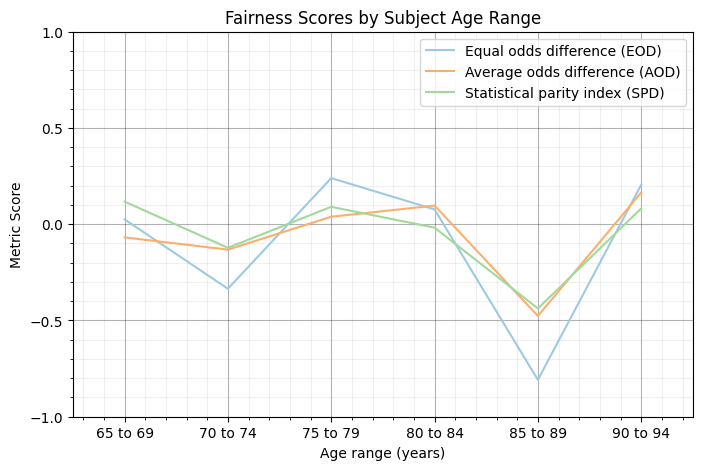

        Age       ACC     SPE     REC       MCC
0  65 to 69  0.890625  1.0000  0.8250  0.799193
1  70 to 74  0.712500  0.8125  0.5625  0.388514
2  75 to 79  1.000000  1.0000  1.0000  1.000000
3  80 to 84  0.803571  0.7750  0.8750  0.596874
4  85 to 89  1.000000  1.0000  1.0000  1.000000
5  90 to 94  0.833333  0.7500  1.0000  0.707107
  Age_range    Weight        DI       EOD       AOD       SPD
0  65 to 69  0.296296  1.295058  0.025000 -0.068382  0.117477
1  70 to 74  0.400000  0.733696 -0.335227 -0.131899 -0.122500
2  75 to 79  0.206897  1.221053  0.239583  0.038909  0.090517
3  80 to 84  0.250000  0.958333  0.076923  0.096795 -0.017857
4  85 to 89  0.029412  0.000000 -0.808333 -0.476535 -0.437500
5  90 to 94  0.093750  1.196262  0.205357  0.165179  0.082031


In [17]:
def graphFairnessByAge():
  fig, ax = plt.subplots(figsize=(8,5))

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.1
  m = 0

  ticks = np.arange(0, len(df_age_fairness["Age_range"].unique()), 1)

  for k in df_age_fairness.keys()[3:]:
    ax.plot(ticks, df_age_fairness[k], label=abbr[k], color=cmap_tab(i))
    i+=0.2
    m+=1

  ax.set_xticks(ticks=ticks, labels=df_age_fairness["Age_range"].unique())

  ax.set_yticks([-1.,-0.5 ,0., 0.5, 1.])
  ax.set_yticks(np.arange(-1., 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel("Age range (years)")
  ax.set_ylabel("Metric Score")
  ax.set_title("Fairness Scores by Subject Age Range")

  plt.legend()
  savefigtight("fairness-age.png")
  plt.show()

graphFairnessByAge()
print(df_age)
print(df_age_fairness)

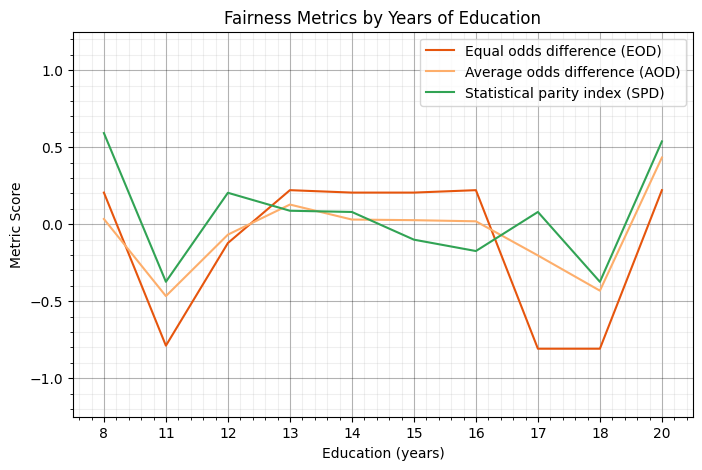

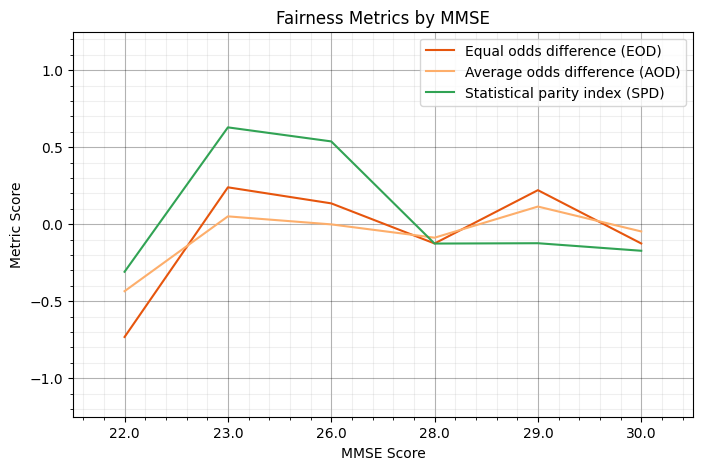

In [18]:
def graphFairnessByUnique(key, xlabel, title, filename):
  fig, ax = plt.subplots(figsize=(8,5))
  df_unique = fairnessByUnique(df_pred, key).sort_values(by=key)

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.2
  m = 0

  ticks = np.arange(0, len(df_unique[key].unique()), 1)

  for k in df_unique.keys()[3:]:
    ax.plot(ticks, df_unique[k], label=abbr[k], color=cmap_tab(i))
    i+=0.1
    m+=1

  ax.set_xticks(ticks=ticks, labels=df_unique[key].unique())

  ax.set_yticks([-1.,-0.5 ,0., 0.5, 1.])
  ax.set_ylim(-1.25, 1.25)
  ax.set_yticks(np.arange(-1., 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel(xlabel)
  ax.set_ylabel("Metric Score")
  ax.set_title(title)

  plt.legend()
  savefigtight(filename)
  plt.show()

graphFairnessByUnique("EDUC_raw","Education (years)", "Fairness Metrics by Years of Education", "fairness-educ.png")
graphFairnessByUnique("MMSE_raw","MMSE Score", "Fairness Metrics by MMSE", "fairness-mmse.png")


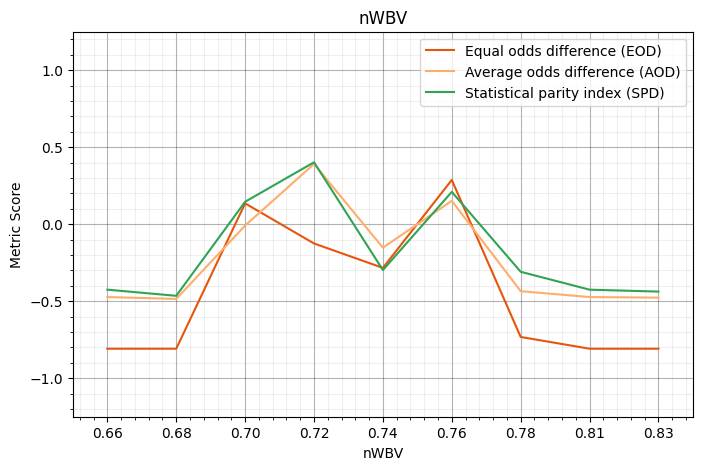

In [19]:
def graphFairnessByUniqueRange(key, xlabel, title, filename):
  fig, ax = plt.subplots(figsize=(8,5))
  df_unique = fairnessByRange(df_pred, key, 10).sort_values(by=key)

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.2
  m = 0

  ticks = np.arange(0, len(df_unique[key].unique()), 1)

  for k in df_unique.keys()[3:]:
    ax.plot(ticks, df_unique[k], label=abbr[k], color=cmap_tab(i))
    i+=0.1
    m+=1

  ax.set_xticks(ticks=ticks, labels=[f'{u:.2f}' for u in  df_unique[key].unique()])

  ax.set_yticks([-1.,-0.5 ,0., 0.5, 1.])
  ax.set_ylim(-1.25, 1.25)
  ax.set_yticks(np.arange(-1., 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel(xlabel)
  ax.set_ylabel("Metric Score")
  ax.set_title(title)

  plt.legend()
  savefigtight(filename)
  plt.show()

graphFairnessByUniqueRange("nWBV_raw","nWBV", "nWBV", "nWBV.png")


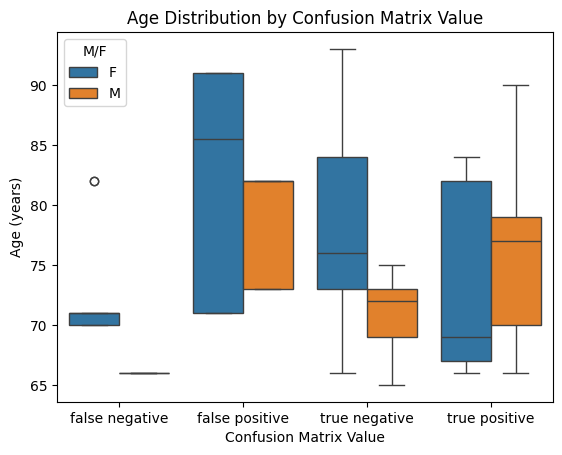

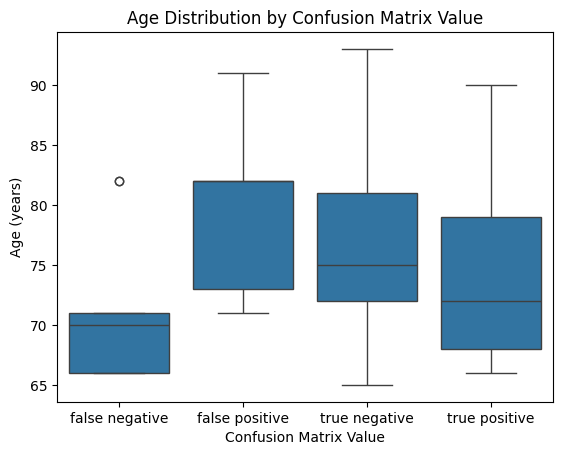

In [20]:

sns.boxplot(data=df_pred.sort_values(by="CM_full"), y="Age_raw", x="CM_full", hue="M/F", orient='v')
plt.ylabel("Age (years)")
plt.xlabel("Confusion Matrix Value")
plt.title("Age Distribution by Confusion Matrix Value")
savefigtight("age-sex-boxplot-cm.png")
plt.show()

sns.boxplot(data=df_pred.sort_values(by="CM_full"), y="Age_raw", x="CM_full")
plt.xlabel("Confusion Matrix Value")
plt.ylabel("Age (years)")
plt.title("Age Distribution by Confusion Matrix Value")
savefigtight("age-boxplot-cm.png")
plt.show()


# Images

In [21]:
acc = []
mri = []
g=[]
for i in df_pred["MRI ID"].sort_values().unique():
  acc += [accuracy(df_pred[df_pred["MRI ID"] == i])]
  mri += [i]
  g += [df_pred[df_pred["MRI ID"] == i]["Group_norm"].iloc[0]]

df_t = pd.DataFrame({"MRI ID": mri, "Group":g, "ACC": acc})
print(df_t.query("ACC == 0.5"))

           MRI ID  Group  ACC
20  OAS2_0096_MR2      0  0.5


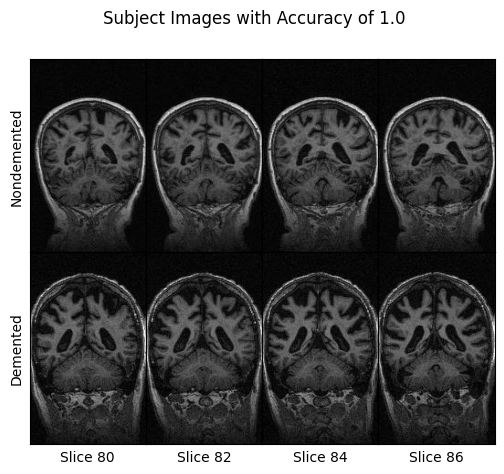

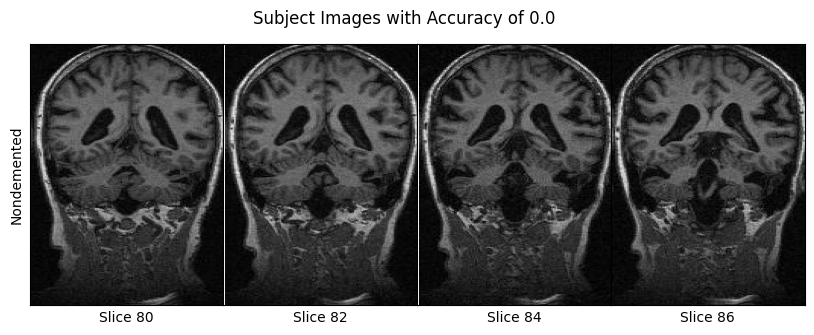

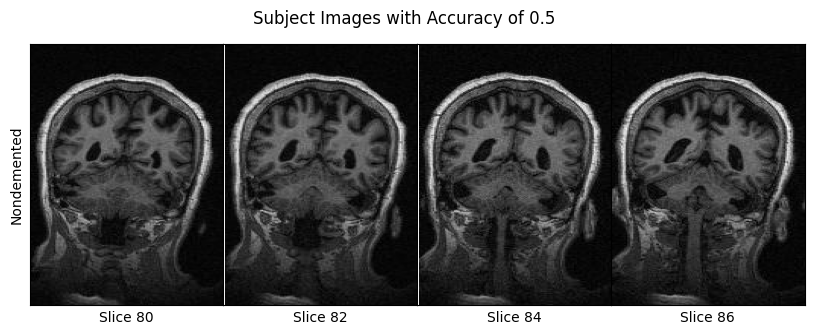

In [22]:
def plotTestingImage(basenames, title, filename):
  slices = [80, 82, 84, 86]
  rows = len(basenames)
  gspec = mpl.gridspec.GridSpec(rows, 4)
  gspec.update(wspace=0, hspace=0)
  # fig, ax = plt.subplots(rows, 4, sharex='all', sharey='all', tight_layout="tight")

  for r in range(rows):
    for i, slice in enumerate(slices):
      ax = plt.subplot(gspec[r*4+i])
      fname = f'{os.path.join(os.getenv("JPG"), "test", basenames[r])}_{slice}.jpg'
      image = plt.imread(fname)
      tr = mpl.transforms.Affine2D().translate(-128, -240).rotate_deg(180)
      ax.imshow(image, transform=tr+ax.transData)
      # ax.get_xaxis().set_visible(False)
      # ax.get_yaxis().set_visible(False)

      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_aspect('auto')
      if r == rows-1:
        ax.set_xlabel(f"Slice {slice}")
      if i == 0:
        if r==0:
          ax.set_ylabel("Nondemented")
        if r==1:
          ax.set_ylabel("Demented")
  plt.suptitle(title)
  savefigtight(filename)
  plt.show()
plt.figure(figsize=(6,5))


plotTestingImage(["class_0/OAS2_0008_MR1_V1","class_1/OAS2_0016_MR2_V1"], "Subject Images with Accuracy of 1.0", "acc-100-slices.png")

plt.figure(figsize=(10,3.4))
plotTestingImage(["class_0/OAS2_0070_MR2_V1"], "Subject Images with Accuracy of 0.0", "acc-0-slices.png")
plt.figure(figsize=(10,3.4))

plotTestingImage(["class_0/OAS2_0096_MR2_V1"], "Subject Images with Accuracy of 0.5", "acc-50-slices.png")


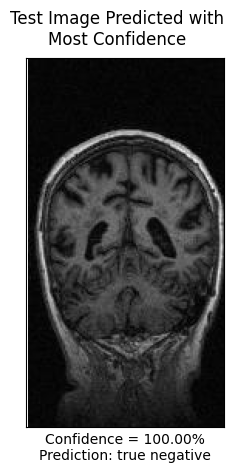

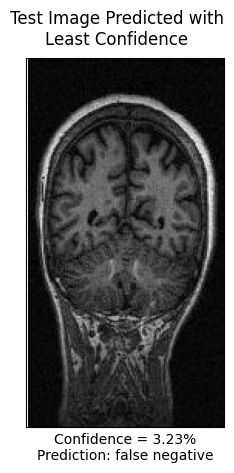

In [23]:
def makeSingleTestImage(imagefile, title, filename, xlabel=""):
  image = plt.imread(os.path.join(os.getenv("JPG"), "test", imagefile))
  gspec = mpl.gridspec.GridSpec(1, 1)
  gspec.update(wspace=0, hspace=0)

  ax = plt.subplot(gspec[0])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect('auto')

  tr = mpl.transforms.Affine2D().translate(-128, -240).rotate_deg(180)
  ax.imshow(image, transform=tr+ax.transData)
  ax.set_xlabel(xlabel)
  plt.suptitle(title)

  savefigtight(filename)
  plt.show()



conf_max = df_pred[df_pred["Confidence"] == df_pred["Confidence"].max()].iloc[0]
conf_min = df_pred[df_pred["Confidence"] == df_pred["Confidence"].min()].iloc[0]

makeSingleTestImage(os.path.join("class_0" if conf_max["Group_norm"]==0 else "class_1", conf_max["File"]), 'Test Image Predicted with\nMost Confidence', "most-confidence.png", f'Confidence = {conf_max["Confidence"]*100:.2f}%\nPrediction: {str(conf_max["CM_full"])}')
makeSingleTestImage(os.path.join("class_0" if conf_min["Group_norm"]==0 else "class_1", conf_min["File"]), 'Test Image Predicted with\nLeast Confidence', "least-confidence.png", f'Confidence = {conf_min["Confidence"]*100:.2f}%\nPrediction: {str(conf_min["CM_full"])}')


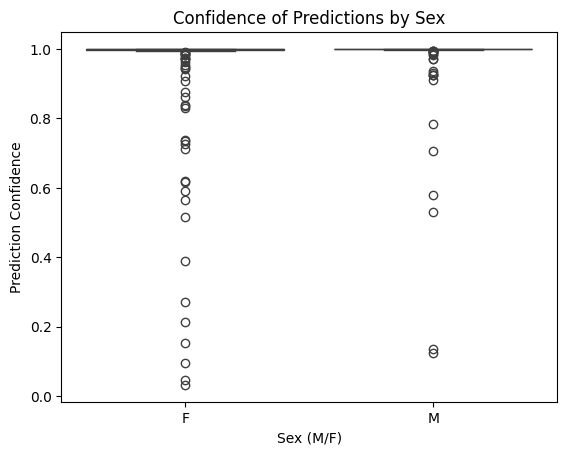

In [24]:

sns.boxplot(data=df_pred, x="M/F", y="Confidence", hue="M/F")
plt.title("Confidence of Predictions by Sex")
plt.xlabel("Sex (M/F)")
plt.ylabel("Prediction Confidence")
savefigtight("conf-sex-boxplot.png")
plt.show()


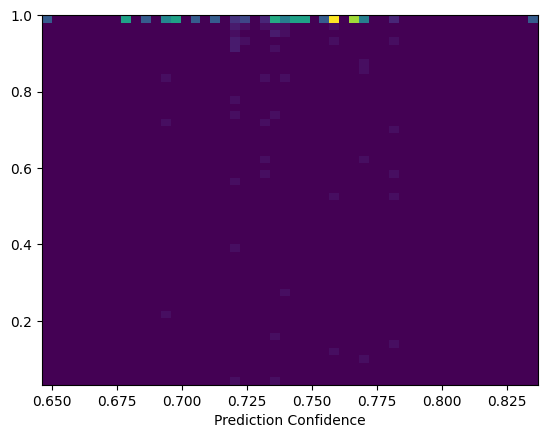

In [25]:

plt.hist2d(x=df_pred["nWBV_raw"], y=df_pred["Confidence"], bins=50, density=True)
plt.xlabel("nWBV")
plt.xlabel("Prediction Confidence")
plt.show()